In [42]:
import pandas as pd
import os
import glob as gb
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
model_path = "/content/drive/My Drive/Colab Notebooks/identify_sign.h5"
loaded_model = keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

#image = cv2.imread("/content/drive/My Drive/Signatures_detect/forge/02100002.png")
image = cv2.imread("/content/drive/My Drive/Signatures_detect/real/00200002.png")
#image = cv2.imread("/content/drive/My Drive/Signature_classify/test/User2/00205002.png")


image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((128, 128))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
result = pred.argmax()
input_user = result + 1
print('The Signature Belongs to: User' + str(input_user))

The Signature Belongs to: User2


## Image forgery detection


In [45]:
#original_signature = cv2.imread("/content/drive/My Drive/Signature_classify/train/User"+ str(input_user)+"/00"+str(input_user)+"0100"+str(input_user)+".png")
original_signatures = []
for i in range(5):
  original_signatures.append("/content/drive/My Drive/Signature_classify/train/User"+ str(input_user)+"/00"+str(input_user)+"0"+str(i)+"00"+str(input_user)+".png")

print(original_signatures)

['/content/drive/My Drive/Signature_classify/train/User2/00200002.png', '/content/drive/My Drive/Signature_classify/train/User2/00201002.png', '/content/drive/My Drive/Signature_classify/train/User2/00202002.png', '/content/drive/My Drive/Signature_classify/train/User2/00203002.png', '/content/drive/My Drive/Signature_classify/train/User2/00204002.png']


In [46]:
input_image = image

In [47]:
import cv2

#Works well with images of different dimensions
def orb_sim(img1, img2):
  # SURF is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches. 
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 60. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 60]  
  if len(matches) == 0:
    return 1
  return len(similar_regions) / len(matches)

# img1 = cv2.imread('/content/drive/My Drive/Car.jpg', 0)  # 714 x 901 pixels
# img3 = cv2.imread('/content/drive/My Drive/Heli.jpg', 0)  # 203 x 256 pixels


#orb_similarity = orb_sim(original_signature, input_image)  #1.0 means identical. Lower = not similar
max_identical = 0
orb_similarity = 0
for i in range(len(original_signatures)):
  original_signature = cv2.imread(original_signatures[i])
  orb_similarity = orb_sim(original_signature, input_image)
  if max_identical < orb_similarity:
    max_identical = orb_similarity


print("Similarity using ORB is: ", max_identical)
if max_identical > 0.7:
  print("The Signature geniune")
else:
  print("The Signature is forged")

Similarity using ORB is:  1.0
The Signature geniune


## SIFT

In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [49]:
def SIFT(image1,image2):
  # Convert the training image to RGB
  training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  testing_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
  # Convert the training image to gray scale
  training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)
  testing_gray = cv2.cvtColor(testing_image, cv2.COLOR_RGB2GRAY)
  # Display traning image and testing image
  fx, plots = plt.subplots(1, 2, figsize=(20,10))
  plots[0].set_title("Training Image")
  plots[0].imshow(training_image)
  plots[1].set_title("Testing Image")
  plots[1].imshow(testing_image)
  #now checking whether the image matches using SIFT algorithm
  surf = cv2.SIFT_create()

  train_keypoints, train_descriptor = surf.detectAndCompute(training_gray, None)
  test_keypoints, test_descriptor = surf.detectAndCompute(testing_gray, None)

  keypoints_without_size = np.copy(training_image)
  keypoints_with_size = np.copy(training_image)

  keypoints_without_size1 = np.copy(testing_image)
  keypoints_with_size1 = np.copy(testing_image)

  cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

  cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  cv2.drawKeypoints(testing_image, test_keypoints, keypoints_without_size1, color = (0, 255, 0))

  cv2.drawKeypoints(testing_image, test_keypoints, keypoints_with_size1, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  # Display image with and without keypoints size
  fx, plots = plt.subplots(1, 2, figsize=(20,10))

  plots[0].set_title("Train keypoints With Size")
  plots[0].imshow(keypoints_with_size, cmap='gray')

  plots[1].set_title("Train keypoints Without Size")
  plots[1].imshow(keypoints_without_size, cmap='gray')

  # Print the number of keypoints detected in the training image
  print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

  # Print the number of keypoints detected in the query image
  print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

  # Perform the matching between the SURF descriptors of the training image and the test image
  matches = bf.match(train_descriptor, test_descriptor)

  # The matches with shorter distance are the ones we want.
  matches = sorted(matches, key = lambda x : x.distance)
  similar_regions=[i for i in matches if i.distance<1000 ]

  # if(len(matches)==0):
  #     return 0
  return (len(similar_regions)/len(matches))


Number of Keypoints Detected In The Training Image:  25
Number of Keypoints Detected In The Query Image:  25
Number of Keypoints Detected In The Training Image:  28
Number of Keypoints Detected In The Query Image:  25
Number of Keypoints Detected In The Training Image:  25
Number of Keypoints Detected In The Query Image:  25
Number of Keypoints Detected In The Training Image:  20
Number of Keypoints Detected In The Query Image:  25
Number of Keypoints Detected In The Training Image:  20
Number of Keypoints Detected In The Query Image:  25
Similarity using SIFT is:  1.0
The Signature geniune


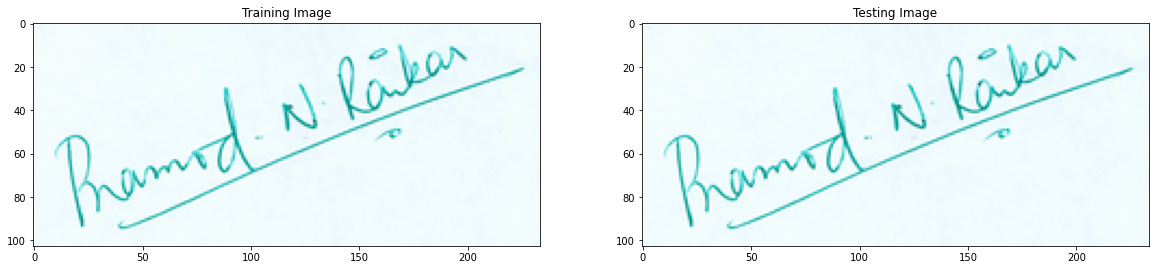

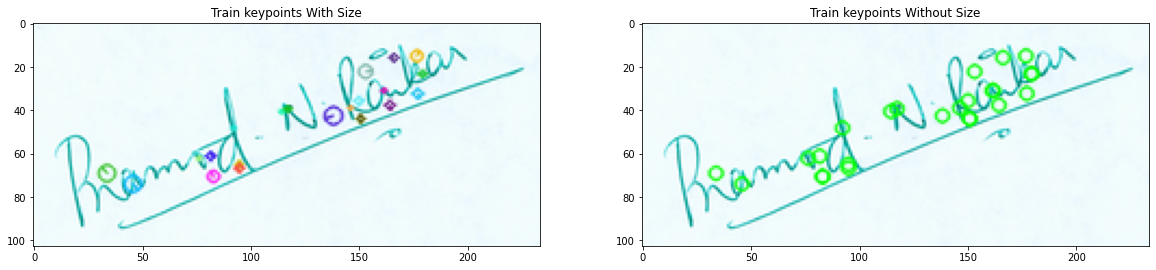

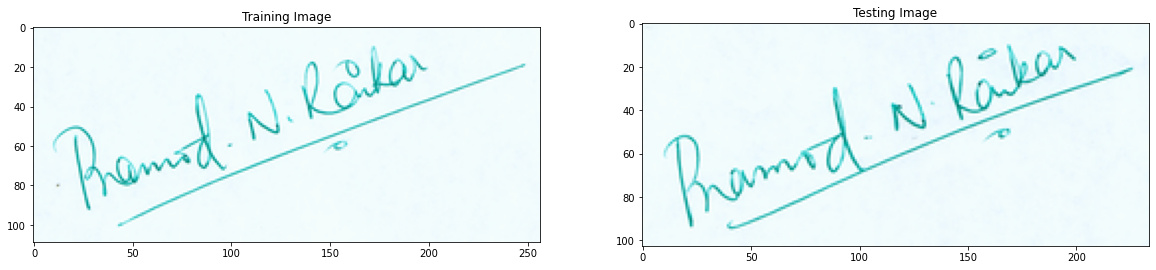

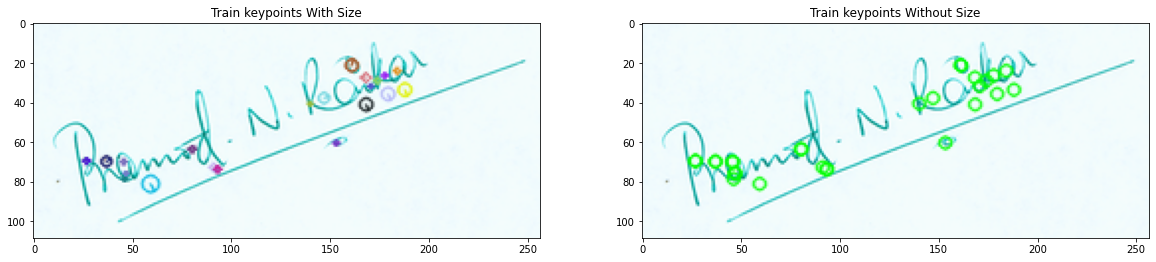

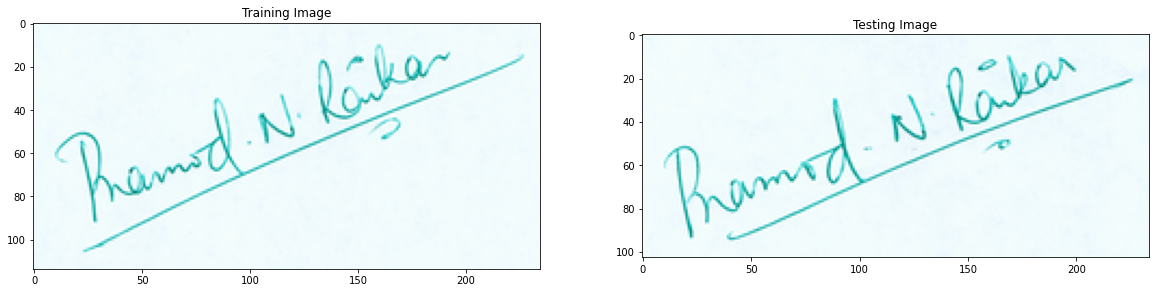

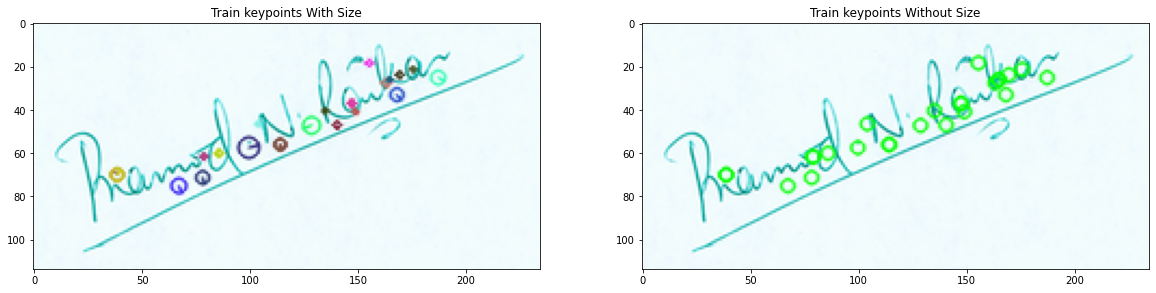

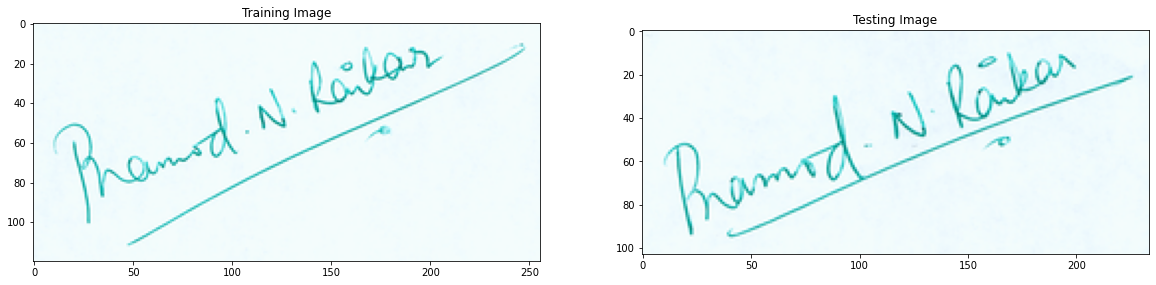

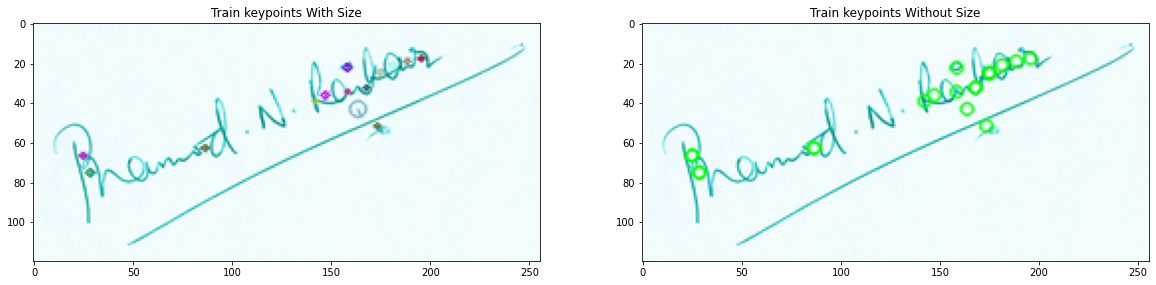

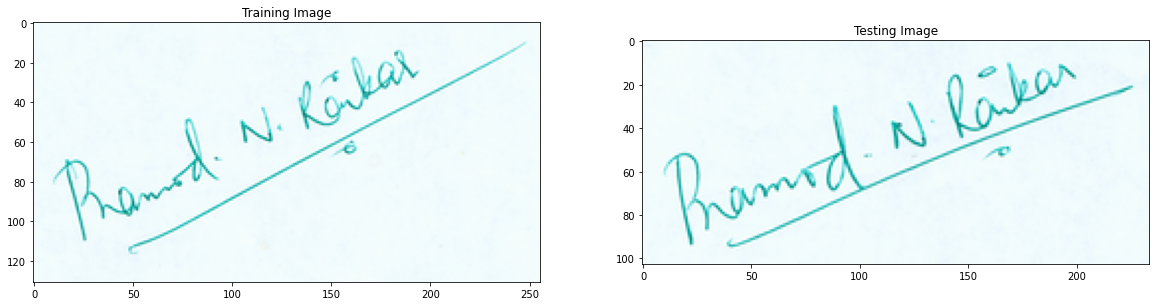

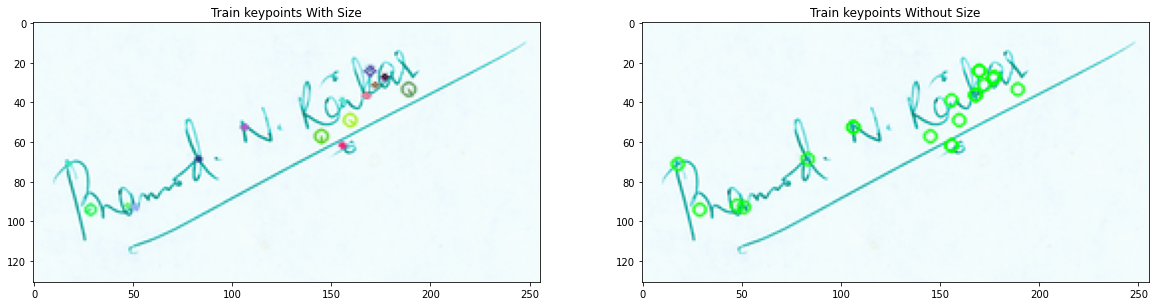

In [50]:
max_identical = 0
sift_similarity = 0
for i in range(len(original_signatures)):
  original_signature = cv2.imread(original_signatures[i])
  sift_similarity = SIFT(original_signature, input_image)
  if max_identical < sift_similarity:
    max_identical = sift_similarity


print("Similarity using SIFT is: ", max_identical)
if max_identical > 0.2:
  print("The Signature geniune")
else:
  print("The Signature is forged")